Please complete the `NotImplemented` parts of the code cells and write your answers in the markdown cells designated for your response to any questions asked. The tag `# AUTOGRADED` (all caps, with a space after `#`) should be at the beginning of each autograded code cell, so make sure that you do not change that. You are also not allowed to import any new package other than the ones already imported. Doing so will prevent the autograder from grading your code.

For the code submission, run the last cell in the notebook to create the submission zip file. If you are working in Colab, make sure to download and then upload a copy of the completed notebook itself to its working directory to be included in the zip file. Finally, submit the zip file to Gradescope.

If you are running the notebook locally, make sure you have created a virtual environment (using `conda` for example) and have the proper packages installed. We are working with `python=3.10` and `torch>=2`.

Files to be included in submission:

- `HW3.ipynb`

# Implement a 2D convolution function
This week you learned about the convolution operation, which is the central operation of Convolutional Neural Networks (CNNs). In this homework, you are going to implement a 2D convolution function using numpy, so that you understand its nuts and bolts, as well as some extended variations of the convolution: strided, dilated, and grouped convolution.

In [3]:
# DO NOT CHANGE THIS CELL OR ADD ANY ADDITIONAL IMPORTS!

import os
import zipfile
import numpy as np
from typing import Tuple, Union

# For interactive plotting:
import matplotlib.pyplot as plt
import ipywidgets as widgets
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except ImportError:
    pass
try:
    %matplotlib widget
except:
    %pip install ipympl
    %matplotlib widget

# a helper function to convert a single value to a tuple:
def to_tuple(
        x: Union[int, Tuple[int, int]]
        ) -> Tuple[int, int]:
    
    if isinstance(x, tuple):
        return x
    return (x, x)

## Padding, Stride, and Dilation

In the simple convolution, the convolution kernel (filter) is applied to different locations in the input like a sliding window. By 'applied' we mean that the inner product (sum of the element-wise multiplication) of the kernel with the chosen window of the input is calculated, and the result is stored to the corresponding location in the output. As the inner product of two vectors show how similar their direction is, you can think of the convolution as a pattern matching that is done everywhere in the input. 

In order to increase the convenience of convolution in certain aspects, several modifications can be applied:

- Padding: padding is extending the input over its edges, which is usually done to keep the output shape the same as input. Without padding, the output shape is going to be smaller, which may sometimes be undesirable. The values at the extentions over the edges are arbitrary, but the default is 0 (zero-padding). Usually the padding size is the same on both ends of each axis, but may be different for each axis.

- Stride: the stride is the step that the sliding window takes each time over the input. By increasing the stride, the pattern matching becomes less exhaustive, and the output will have a smaller shape. For example, if stride is 2, the sliding window skips every other index, and the output shape in each axis is almost halved.

- Dilation: while the simple convolution applies the kernel to a compact window, the sliding window of a dilated convolution is dilated. This may be understood more easily with visualization in the link that we provide below.

You can look at [Convolution Arithmetic Visualizations](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) to better understand these concepts. We are not discussing transposed convolution here. The animation for the dilated convolution (the last animation) corresponds to `dilation=2` in each axis. The dilation can be any positive integer, and your code should work for any dilation.

Now, you have to implement a code to correctly calculate the output shape and the slice of the input that is used the calculate the output at location `(i, j)`, based on the input shape, padding, stride, and dilation.

For each of these arguments, you can pass one integer (which will be used for both axes), or a tuple that contains the value for each axis.

Below you will find an interactive plotting class that can help you visualize a convolution configuration. The two parts that you have to implement are marked with `NotImplemented`. After you fill in your code, run the cell after to get the interactive plot. If your code is correct, you should not get any error for any output location, and you should be able to traverse all the output locations and all the possible input locations.

In [5]:
class ConvViz:

    def __init__(
        self,
        input_shape = Union[int, Tuple[int, int]],
        kernel_shape = Union[int, Tuple[int, int]],
        stride = Union[int, Tuple[int, int]],
        padding = Union[int, Tuple[int, int]],
        dilation = Union[int, Tuple[int, int]],
        ):
        self.X_in, self.Y_in = to_tuple(input_shape)
        self.X_k, self.Y_k = to_tuple(kernel_shape)
        self.sx, self.sy = to_tuple(stride)
        self.px, self.py = to_tuple(padding)
        self.dx, self.dy = to_tuple(dilation)

        # Padded input shape:
        # YOUR CODE
        pad_width = self.X_in + 2 * self.px
        pad_height = self.Y_in + 2 * self.py
        self.padded_shape = (pad_width, pad_height)

        # Output shape:
        # YOUR CODE
        dilated_kernel_x = self.X_k + (self.X_k - 1) * (self.dx - 1)
        dilated_kernel_y = self.Y_k + (self.Y_k - 1) * (self.dy - 1)
        
        self.X_out = (self.padded_shape[0] - dilated_kernel_x) // self.sx + 1
        self.Y_out = (self.padded_shape[1] - dilated_kernel_y) // self.sy + 1

        assert self.X_out > 0 and self.Y_out > 0, 'Convolutional not possible'

    def get_input_slice(
        self,
        i: int,
        j: int,
        ) -> Tuple[slice, slice]:
        # Find the correct slice for the input tensor to be applied to the kernel size
        # use slice(start, end, step) to define the slice for x and y axis.

        # YOUR CODE
        x_start = i * self.sx
        y_start = j * self.sy

        x_end = x_start + (self.X_k - 1) * self.dx + 1
        y_end = y_start + (self.Y_k - 1) * self.dy + 1

        return slice(x_start, x_end, self.dx), slice(y_start, y_end, self.dy)

    def get_field(self, i, j):

        # creates the input field with values:
        # 0.5 for the padded area --> white
        # 0 for the non-padded area --> blue
        # 1 for the convolved area --> red
        plot_input = np.ones(self.padded_shape, dtype=np.float32)/2
        plot_input[self.px:-self.px, self.py:-self.py] = 0
        input_slice = self.get_input_slice(i, j)
        plot_input[input_slice] = 1

        # creates the output field with values:
        # 0 for all values except the current output value --> blue
        # 1 for the current output value --> red
        plot_output = np.zeros((self.X_out, self.Y_out), dtype=np.float32)
        plot_output[i, j] = 1

        return plot_input, plot_output

    def show(self):
        plot_input, plot_output = self.get_field(0, 0)
        self.fig, self.ax = plt.subplots(1, 2, figsize=(10, 5))
        self.in_img = self.ax[0].imshow(plot_input.T, cmap='bwr')
        self.out_img = self.ax[1].imshow(plot_output.T, cmap='bwr')
        self.ax[0].set_title('Input')
        self.ax[1].set_title('Output')
        self.ax[0].set_xlabel('x')
        self.ax[0].set_ylabel('y')
        self.ax[1].set_xlabel('x')
        self.ax[1].set_ylabel('y')
        self.ax[0].set_xticks(np.arange(self.X_in+2*self.px)-0.5)
        self.ax[0].set_yticks(np.arange(self.Y_in+2*self.py)-0.5)
        self.ax[1].set_xticks(np.arange(self.X_out)-0.5)
        self.ax[1].set_yticks(np.arange(self.Y_out)-0.5)
        self.ax[0].grid(color='black')
        self.ax[1].grid(color='black')
        self.ax[0].set_xticklabels(np.arange(self.X_in+2*self.px))
        self.ax[0].set_yticklabels(np.arange(self.Y_in+2*self.py))
        self.ax[1].set_xticklabels(np.arange(self.X_out))
        self.ax[1].set_yticklabels(np.arange(self.Y_out))
        self.i = widgets.IntSlider(min=0, max=self.X_out-1, description='i', layout={'width': '300px'})
        self.j = widgets.IntSlider(min=0, max=self.Y_out-1, description='j', layout={'width': '300 px'})
        widgets.interact(self.update, i=self.i, j=self.j)

    def update(self, i, j):
        plot_input, plot_output = self.get_field(i, j)
        self.in_img.set_data(plot_input.T)
        self.out_img.set_data(plot_output.T)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='300px'), max=4), IntSlider(valu…

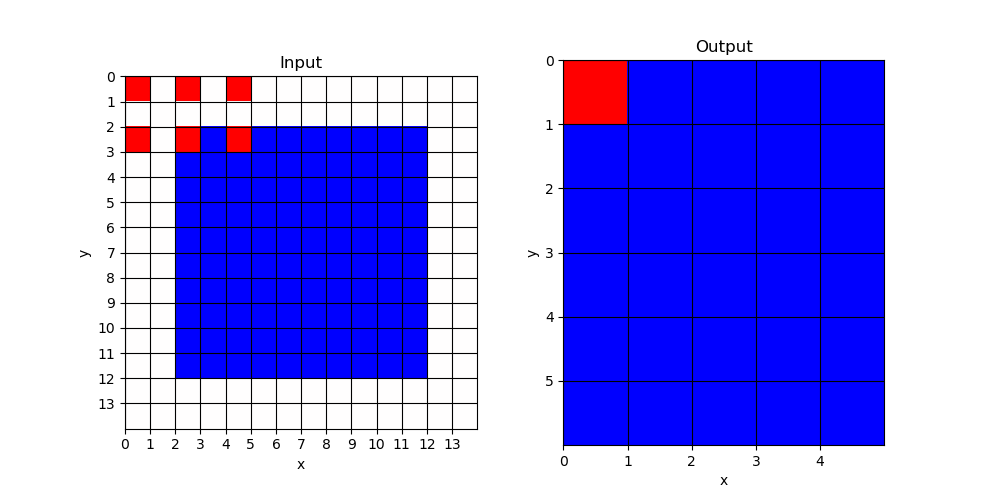

In [7]:
# Change the arguments to arbitrary values to test your code
conv_viz = ConvViz(
    input_shape = (10, 10), 
    kernel_shape = (3, 2), 
    stride = (2, 2), 
    padding = (2, 2), 
    dilation = (2, 2),
    )
conv_viz.show()

## Fill in `conv2d` (90)

Now that you have learned about padding, stride, and dilation, you can implement a 2D convolution. Your task is to complete the function provided in the next cell only using `numpy`. After you are done, you can use `torch.nn.functional.conv2d` to test your function in the two cells after. 

Here, we introduce another modified version of colvolution called grouped convolution, which is about the input and output channels. In the default convolution, each output channels has its own kernel of shape $(c_{in}, X_k, Y_k)$ and the sliding window is actually a 3D cube over all input channels and the spatial window. Therefore, the full kernel is of shape $(c_{out}, c_{in}, X_k, Y_k)$. In grouped convolution, the input and output channels are split into several groups and each group is calculated like an independent default convolution. You can read [`torch.nn.Conv2D()` documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) for a better understanding. The kernel of each group will be of shape $(\dfrac{c_{out}}{n_{groups}}, \dfrac{c_{in}}{n_{groups}}, X_k, Y_k)$, and by putting them together, the full kernel is of shape $(c_{out}, \dfrac{c_{in}}{n_{groups}}, X_k, Y_k)$.

Note: You should not use any `for` loops other than the ones provided. In general, avoiding `for` loops is important to increase the efficiency of your code. Each `for` loop will have a penalty of -5 on your grade. Some hints are provided for you on how to work with the tensors to be able to implement the convolution without explicit loops.

In [9]:
# AUTOGRADED

def conv2d(
        Input: np.ndarray, # shape: (c_in, X_in, Y_in)
        Kernel: np.ndarray, # shape: (c_out, c_in_per_group, X_kernel, Y_kernel)
        Bias: np.ndarray = np.array(0.), # shape: (c_out,) or (1,) or () (broadcastable to (c_out,))

        stride: Union[int, Tuple[int, int]] = 1,
        padding: Union[int, Tuple[int, int]] = 0,
        dilation: Union[int, Tuple[int, int]] = 1,
        groups: int = 1,

        ) -> np.ndarray: # shape: (c_out, X_out, Y_out)

    sx, sy = to_tuple(stride)
    px, py = to_tuple(padding)
    dx, dy = to_tuple(dilation)

    c_in, X_in, Y_in = Input.shape
    c_out, c_in_per_group, X_k, Y_k = Kernel.shape

    assert groups*c_in_per_group == c_in, f"groups * c_in_per_group == c_in should hold ({groups} * {c_in_per_group} != {c_in})"
    assert c_out % groups == 0, f"c_out % groups == 0 should hold ({c_out} % {groups} != 0)"

    # Calculate the output dimensions (in x and y axes)

    # YOUR CODE
    X_out = (X_in + 2 * px - (X_k - 1) * dx - 1) // sx + 1
    Y_out = (Y_in + 2 * py - (Y_k - 1) * dy - 1) // sy + 1

    assert X_out > 0 and Y_out > 0, "Convolution not possible"

    # Pad the input. (you can use np.pad). Look up the documentation to see how to use it.
    # YOUR CODE
    Input = np.pad(Input, ((0, 0), (px, px), (py, py)), mode='constant', constant_values=0)

    # Group the input and output channels in the input and kernel:
    # HINT: if you want to group a dimension of size N such that it becomes G groups, each with N//G elements,
    # where the first group is [0:N//G], the second is [N//G:2*N//G], etc. you can reshape that dimension to (G, N//G).
    # YOUR CODE
    c_out_per_group = c_out // groups
    Input = Input.reshape(groups, c_in_per_group, X_in + 2 * px, Y_in + 2 * py)
    Kernel = Kernel.reshape(groups, c_out_per_group, c_in_per_group, X_k, Y_k)

    # Initialize the output with dtype np.float32 (The shape is your choice. choose wisely!)
    # YOUR CODE
    Output = np.empty((groups, c_out_per_group, X_out, Y_out), dtype=np.float32)

    # Calculate the output elements one location at a time (sliding window over input)
    for i in range(X_out):
        for j in range(Y_out):
            # Calculating output at position (i, j)
        
            # select the correct slice of the input for the calculation of this output (call it Input_slice)
            # YOUR CODE
            x_start = i * sx
            y_start = j * sy
            x_end = x_start + (X_k - 1) * dx + 1
            y_end = y_start + (Y_k - 1) * dy + 1

            Input_slice = Input[:, :, x_start:x_end:dx, y_start:y_end:dy]  # (groups, c_in_per_group, X_k, Y_k)

            # Calculate the convolution and assign it to the output element at position (i, j)
            # HINT: you may benefit from a dummy dimension somewhere to make some operation broadcastable
            # YOUR CODE
            Output[:, :, i, j] = np.sum(Input_slice[:, None, :, :, :] * Kernel, axis=(2, 3, 4))


    # Reshape the output to final correct shape (c_out, X_out, Y_out)
    # YOUR CODE
    Output = Output.reshape(c_out, X_out, Y_out)
    
    # Add the bias across output channel dimension (broadcast across the other dimensions)
    # Be careful. Bias might be of shape () or (1,) or (c_out,).
    # YOUR CODE
    Output += Bias.reshape(-1, 1, 1)

    return Output

In [11]:
# ARBITRARY SETTINGS FOR TESTING:

# Input and output 
c_in , X_in, Y_in = 32, 28, 28
c_out = 64

# Kernel size:
X_k, Y_k = 3, 3

# Convolution hyperparameters:
stride = (1, 1)
padding = (0, 0)
dilation = (1, 1)
groups = 1

assert c_in % groups == 0, "c_in should be divisible by groups"
assert c_out % groups == 0, "c_out should be divisible by groups"


In [13]:
# TESTING WITH RANDOM INPUTS:

# Run this cell several times to test your function's output

import torch
import torch.nn.functional as F


# Random input, kernel and bias
Input = np.random.randn(c_in, X_in, Y_in).astype(np.float32)
Kernel = np.random.randn(c_out, c_in//groups, X_k, Y_k).astype(np.float32)
Bias = np.random.randn(c_out).astype(np.float32)

# Calculate the output using your function
your_output = conv2d(Input, Kernel, Bias, stride, padding, dilation, groups)

# Calculate the output using PyTorch
Input_torch = torch.tensor(Input[None, ...]) # A dummy dimension as the batch dimension
Kernel_torch = torch.tensor(Kernel)
Bias_torch = torch.tensor(Bias)
torcX_output = F.conv2d(Input_torch, Kernel_torch, Bias_torch, stride=stride, padding=padding, dilation=dilation, groups=groups)[0]

# Calculate the relative L2 norm error
# If your output is of the wrong shape, this will raise an error
torch.testing.assert_close(torch.as_tensor(your_output), torcX_output, rtol=1e-3, atol=1e-3)

# Implement average pooling using `conv2d` (10)

Pooling is a simple way to reduce the memory cost of convolutional neural networks. The most common types of pooling layers are average pooling and max pooling, where the average or maximum of the elements in the sliding window is calculated as the corresponding output for that window. You are going to implement average pooling as a special case of convolution. You will have to define the convolution filter based on the pooling kernel shape. Pooling is done per channel, meaning that each output channel cororesponds to the input channel. After you are done, you will use `torch.nn.functional.avg_pool2d` to test your function. Remember that you can only use `numpy`, not `torch`.

In [27]:
# AUTOGRADED

def avg_pool2d(
        Input: np.ndarray, # shape: (c, X_in, Y_in)
        kernel_size: Union[int, Tuple[int, int]],
        stride: Union[int, Tuple[int, int]],
        padding: Union[int, Tuple[int, int]],
        ):
    
    c, X_in, Y_in = Input.shape
    X_k, Y_k = to_tuple(kernel_size)
    sx, sy = to_tuple(stride)
    px, py = to_tuple(padding)

    # Design the pooling kernel based on input and kernel size
    # YOUR CODE
    pool_kernel = np.full((c, 1, X_k, Y_k), 1 / (X_k * Y_k), dtype=np.float32)

    # Calculate the output using your conv2d function and the correct arguments
    # YOUR CODE
    output = conv2d(
                Input.astype(np.float32), 
                pool_kernel.astype(np.float32), 
                Bias=np.array(0., dtype=np.float32), 
                stride=stride, 
                padding=padding, 
                dilation=1, 
                groups=c
            ).astype(np.float64)

    #print(f"conv2d output dtype: {output.dtype}") 
    
    return output

In [29]:
# test config

c = 5
X_in, Y_in = 13, 15
kernel_size = (4, 4)
stride = (3, 2)
padding = (1, 1)

In [31]:
# testing with random inputs (run this cell several times to test your function)

import torch
import torch.nn.functional as F

Input = np.random.randn(c, X_in, Y_in)
your_output = avg_pool2d(Input, kernel_size=kernel_size, stride=stride, padding=padding)

Input_torch = torch.tensor(Input[None, ...])
torch_output = F.avg_pool2d(Input_torch, kernel_size=kernel_size, stride=stride, padding=padding)[0]

torch.testing.assert_close(torch.as_tensor(your_output), torch_output, atol=1e-3, rtol=1e-3)

# Zip submission files

You can run the following cell to zip the generated files for submission.

If you are on Colab, you do not need to have your drive mounted for this. You can just download the notebook file via the download option in the File dropdown menu on the top left, and upload it inside the directory of the notebook runtime (in the Files tab on the left, where the sample_data folder and the generated files are). This is the directory that the notebook has access to. After you upload the notebook file as well, run the next cell to zip the notebook and the submission files and download it for submission.

In [34]:
def zip_files(output_filename, *file_paths):
    with zipfile.ZipFile(output_filename, 'w') as zipf:
        for file_path in file_paths:
            zipf.write(file_path, os.path.basename(file_path))

files_to_zip = ['HW3.ipynb']
output_zip = 'HW3_submission.zip'
zip_files(output_zip, *files_to_zip)